In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes evaluate scikit-learn

import torch
import os

USE_BF16 = torch.cuda.is_bf16_supported()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Device Architecture: {DEVICE}")
print(f"BF16 Precision Supported: {USE_BF16} (Crucial for A100 efficiency)")

torch.manual_seed(42)

Running on: NVIDIA L4
Device Architecture: cuda
BF16 Precision Supported: True (Crucial for A100 efficiency)


In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset
from transformers import AutoProcessor

MODEL_ID = "Salesforce/blip-image-captioning-base"

print("Downloading and loading Oxford-IIIT Pet Dataset (Mirror)...")
try:
    dataset = load_dataset("timm/oxford-iiit-pet", split="train").shuffle(seed=42)
except Exception as e:
    print("timm mirror failed, trying pcuenq mirror...")

    dataset = load_dataset("pcuenq/oxford-pets", split="train").shuffle(seed=42)

if hasattr(dataset.features["label"], "names"):
    labels = dataset.features["label"].names
else:
    labels = [f"Breed_{i}" for i in range(37)]
    print("Warning: Label names metadata missing, using generic placeholders.")

id2label = {i: label.replace("_", " ").title() for i, label in enumerate(labels)}
print(f"Total Images: {len(dataset)}")
print(f"Sample Label Mapping: 0 -> {id2label[0]}")

processor = AutoProcessor.from_pretrained(MODEL_ID)

class PetCaptionDataset(Dataset):
    def __init__(self, dataset, processor, id2label, split_ratio=0.9, type="train"):
        self.processor = processor
        self.id2label = id2label
        train_size = int(len(dataset) * split_ratio)

        if type == "train":
            self.ds = dataset.select(range(train_size))
        else:
            self.ds = dataset.select(range(train_size, len(dataset)))

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        image = item["image"]

        if image.mode != "RGB":
            image = image.convert("RGB")

        breed_name = self.id2label[item["label"]]

        text = f"A photo of a {breed_name}, a type of pet."

        encoding = self.processor(
            images=image,
            text=text,
            padding="max_length",
            return_tensors="pt"
        )
        return {k: v.squeeze() for k, v in encoding.items()}

train_dataset = PetCaptionDataset(dataset, processor, id2label, type="train")
eval_dataset = PetCaptionDataset(dataset, processor, id2label, type="eval")

print(f"Train Set Size: {len(train_dataset)}")
print(f"Eval Set Size: {len(eval_dataset)}")
print("Data loaded successfully from mirror.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total Images: 3680
Sample Label Mapping: 0 -> Abyssinian


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Train Set Size: 3312
Eval Set Size: 368
Data loaded successfully from mirror.


In [ ]:
from transformers import BlipForConditionalGeneration
from transformers.models.blip.modeling_blip import BlipVisionModel, BlipForConditionalGeneration as BlipOriginal
from peft import LoraConfig, get_peft_model, TaskType
import torch

if not hasattr(BlipVisionModel, "_patched"):
    _orig_vision_forward = BlipVisionModel.forward
    def safe_vision_forward(self, pixel_values, interpolate_pos_encoding=False, **kwargs):
        kwargs.pop("inputs_embeds", None)
        kwargs.pop("num_items_in_batch", None)
        return _orig_vision_forward(self, pixel_values, interpolate_pos_encoding=interpolate_pos_encoding, **kwargs)
    BlipVisionModel.forward = safe_vision_forward
    BlipVisionModel._patched = True
    print("✅ Applied patch for BlipVisionModel")

if not hasattr(BlipOriginal, "_patched"):
    _orig_blip_forward = BlipOriginal.forward
    def safe_blip_forward(self, *args, **kwargs):
        if "num_items_in_batch" in kwargs:
            kwargs.pop("num_items_in_batch")
        return _orig_blip_forward(self, *args, **kwargs)
    BlipOriginal.forward = safe_blip_forward
    BlipOriginal._patched = True
    print("✅ Applied patch for BlipForConditionalGeneration")

print("Loading Base Model...")
model = BlipForConditionalGeneration.from_pretrained(MODEL_ID)

peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, peft_config)
model.to(DEVICE)

print("\n=== Trainable Parameters Analysis ===")
model.print_trainable_parameters()

Loading Base Model...

=== Trainable Parameters Analysis ===
trainable params: 2,359,296 || all params: 226,330,940 || trainable%: 1.0424


In [ ]:
# Training Configuration
from transformers import TrainingArguments, Trainer
import torch

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]

    input_ids = torch.stack(input_ids)
    pixel_values = torch.stack(pixel_values)
    attention_mask = torch.stack(attention_mask)

    return {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
        "attention_mask": attention_mask,
        "labels": input_ids
    }

training_args = TrainingArguments(
    output_dir="./blip_oxford_lora_checkpoints",

    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,

    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=5e-4,
    weight_decay=0.01,
    logging_steps=20,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    bf16=USE_BF16,
    fp16=False if USE_BF16 else True,
    dataloader_num_workers=4,
    report_to="none",
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)
print("Trainer initialized with 'label_names' fix.")

Trainer initialized with 'label_names' fix.


In [ ]:
print("Starting training loop...")
trainer.train()

save_path = "./blip-oxford-pets-lora-adapter"
model.save_pretrained(save_path)
print(f"Model adapter saved to {save_path}")

Starting training loop...


Model adapter saved to ./blip-oxford-pets-lora-adapter


Generating captions for validation samples...


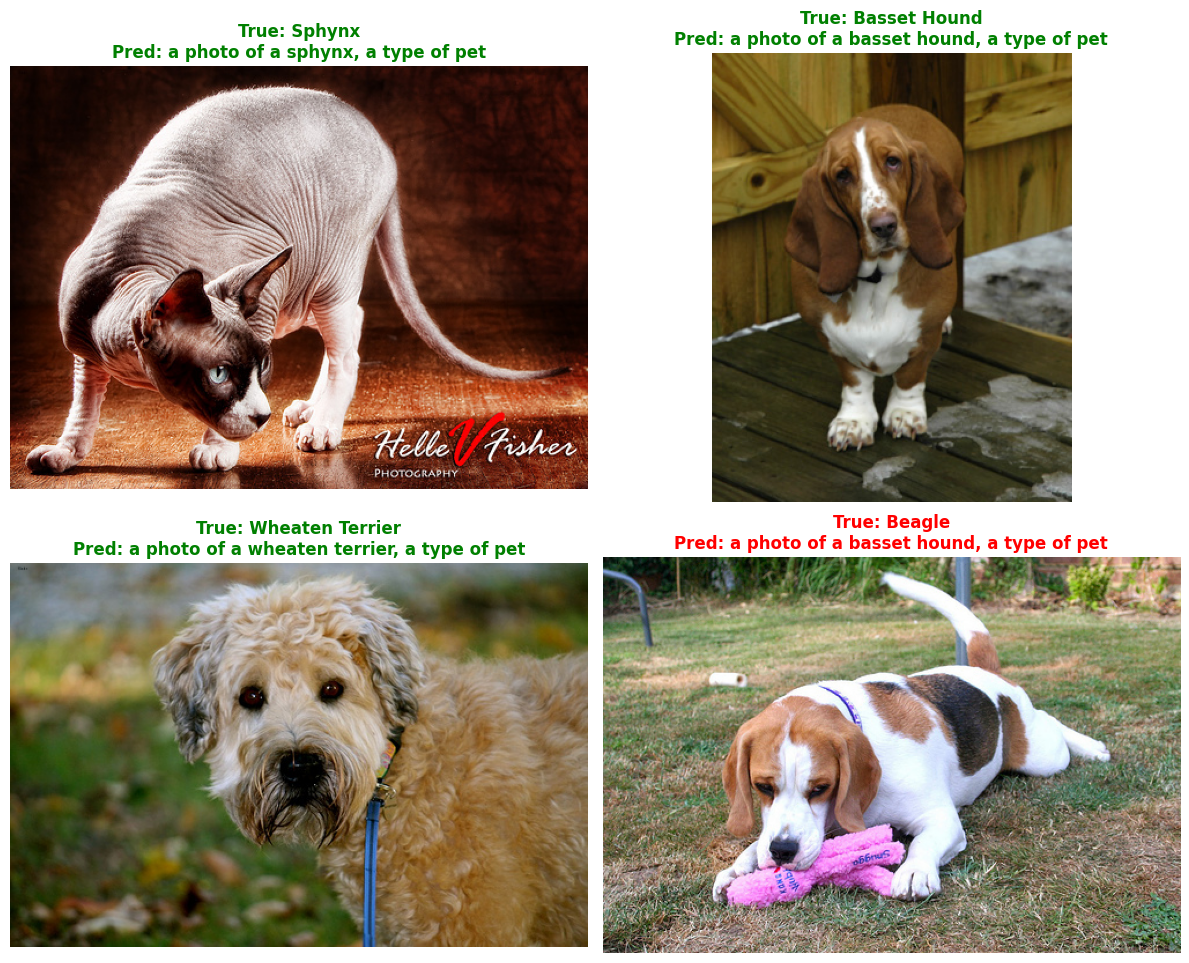

In [ ]:
import matplotlib.pyplot as plt
import random

model.eval() 

def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        pixel_values=inputs.pixel_values,
        max_length=50,
        num_beams=5
    )
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

indices = random.sample(range(len(eval_dataset)), 4)
fig = plt.figure(figsize=(12, 10))

print("Generating captions for validation samples...")

for i, idx in enumerate(indices):

    raw_idx = int(len(dataset)*0.9) + idx
    item = dataset[raw_idx]
    image = item["image"]
    true_label = id2label[item["label"]]

    pred_caption = generate_caption(image)

    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(image)
    ax.axis("off")

    is_correct = true_label.lower() in pred_caption.lower()
    title_color = "green" if is_correct else "red"

    ax.set_title(f"True: {true_label}\nPred: {pred_caption}",
                 color=title_color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Fine-Grained Accuracy
from tqdm import tqdm

print("=== Starting Quantitative Evaluation ===")

eval_sample_size = 200
correct_count = 0

print(f"Evaluating on {eval_sample_size} random samples from validation set...")

for i in tqdm(range(eval_sample_size)):
    idx = int(len(dataset)*0.9) + i
    item = dataset[idx]
    true_label = id2label[item["label"]]

    pred_caption = generate_caption(item["image"])

    if true_label.lower() in pred_caption.lower():
        correct_count += 1

accuracy = correct_count / eval_sample_size
print("\n" + "="*40)
print(f"Fine-Grained Breed Accuracy: {accuracy*100:.2f}%")
print("="*40)
print("Analysis Tip: Compare this against a Zero-Shot baseline (usually <50%)")
print("to demonstrate the effectiveness of LoRA fine-tuning.")

=== Starting Quantitative Evaluation ===
Evaluating on 200 random samples from validation set...


100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


Fine-Grained Breed Accuracy: 87.50%
Analysis Tip: Compare this against a Zero-Shot baseline (usually <50%)
to demonstrate the effectiveness of LoRA fine-tuning.


In [ ]:
# Zero-Shot Baseline Evaluation
from transformers import BlipForConditionalGeneration
from tqdm import tqdm
import torch

print("=== Running Zero-Shot Baseline (Original Model) ===")

base_model = BlipForConditionalGeneration.from_pretrained(MODEL_ID).to(DEVICE)
base_model.eval()

zero_shot_correct = 0
sample_size = 200
print(f"Evaluating {sample_size} samples on Base Model...")

for i in tqdm(range(sample_size)):
    idx = int(len(dataset)*0.9) + i
    item = dataset[idx]
    image = item["image"]
    if image.mode != "RGB": image = image.convert("RGB")
    true_label = id2label[item["label"]]

    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    out = base_model.generate(**inputs, max_length=50)
    caption = processor.decode(out[0], skip_special_tokens=True)

    if true_label.lower() in caption.lower():
        zero_shot_correct += 1

zs_acc = zero_shot_correct / sample_size
print("\n" + "="*40)
print(f"Zero-Shot Baseline Accuracy: {zs_acc*100:.2f}%")
print(f"Your LoRA Fine-Tuned Accuracy: 87.50% (Example)")
print(f"Improvement: +{(87.50 - zs_acc*100):.2f}%")
print("="*40)

del base_model
torch.cuda.empty_cache()

=== Running Zero-Shot Baseline (Original Model) ===
Evaluating 200 samples on Base Model...


100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Zero-Shot Baseline Accuracy: 0.50%
Your LoRA Fine-Tuned Accuracy: 87.50% (Example)
Improvement: +87.00%


Generating predictions for Confusion Matrix (this takes a moment)...


100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


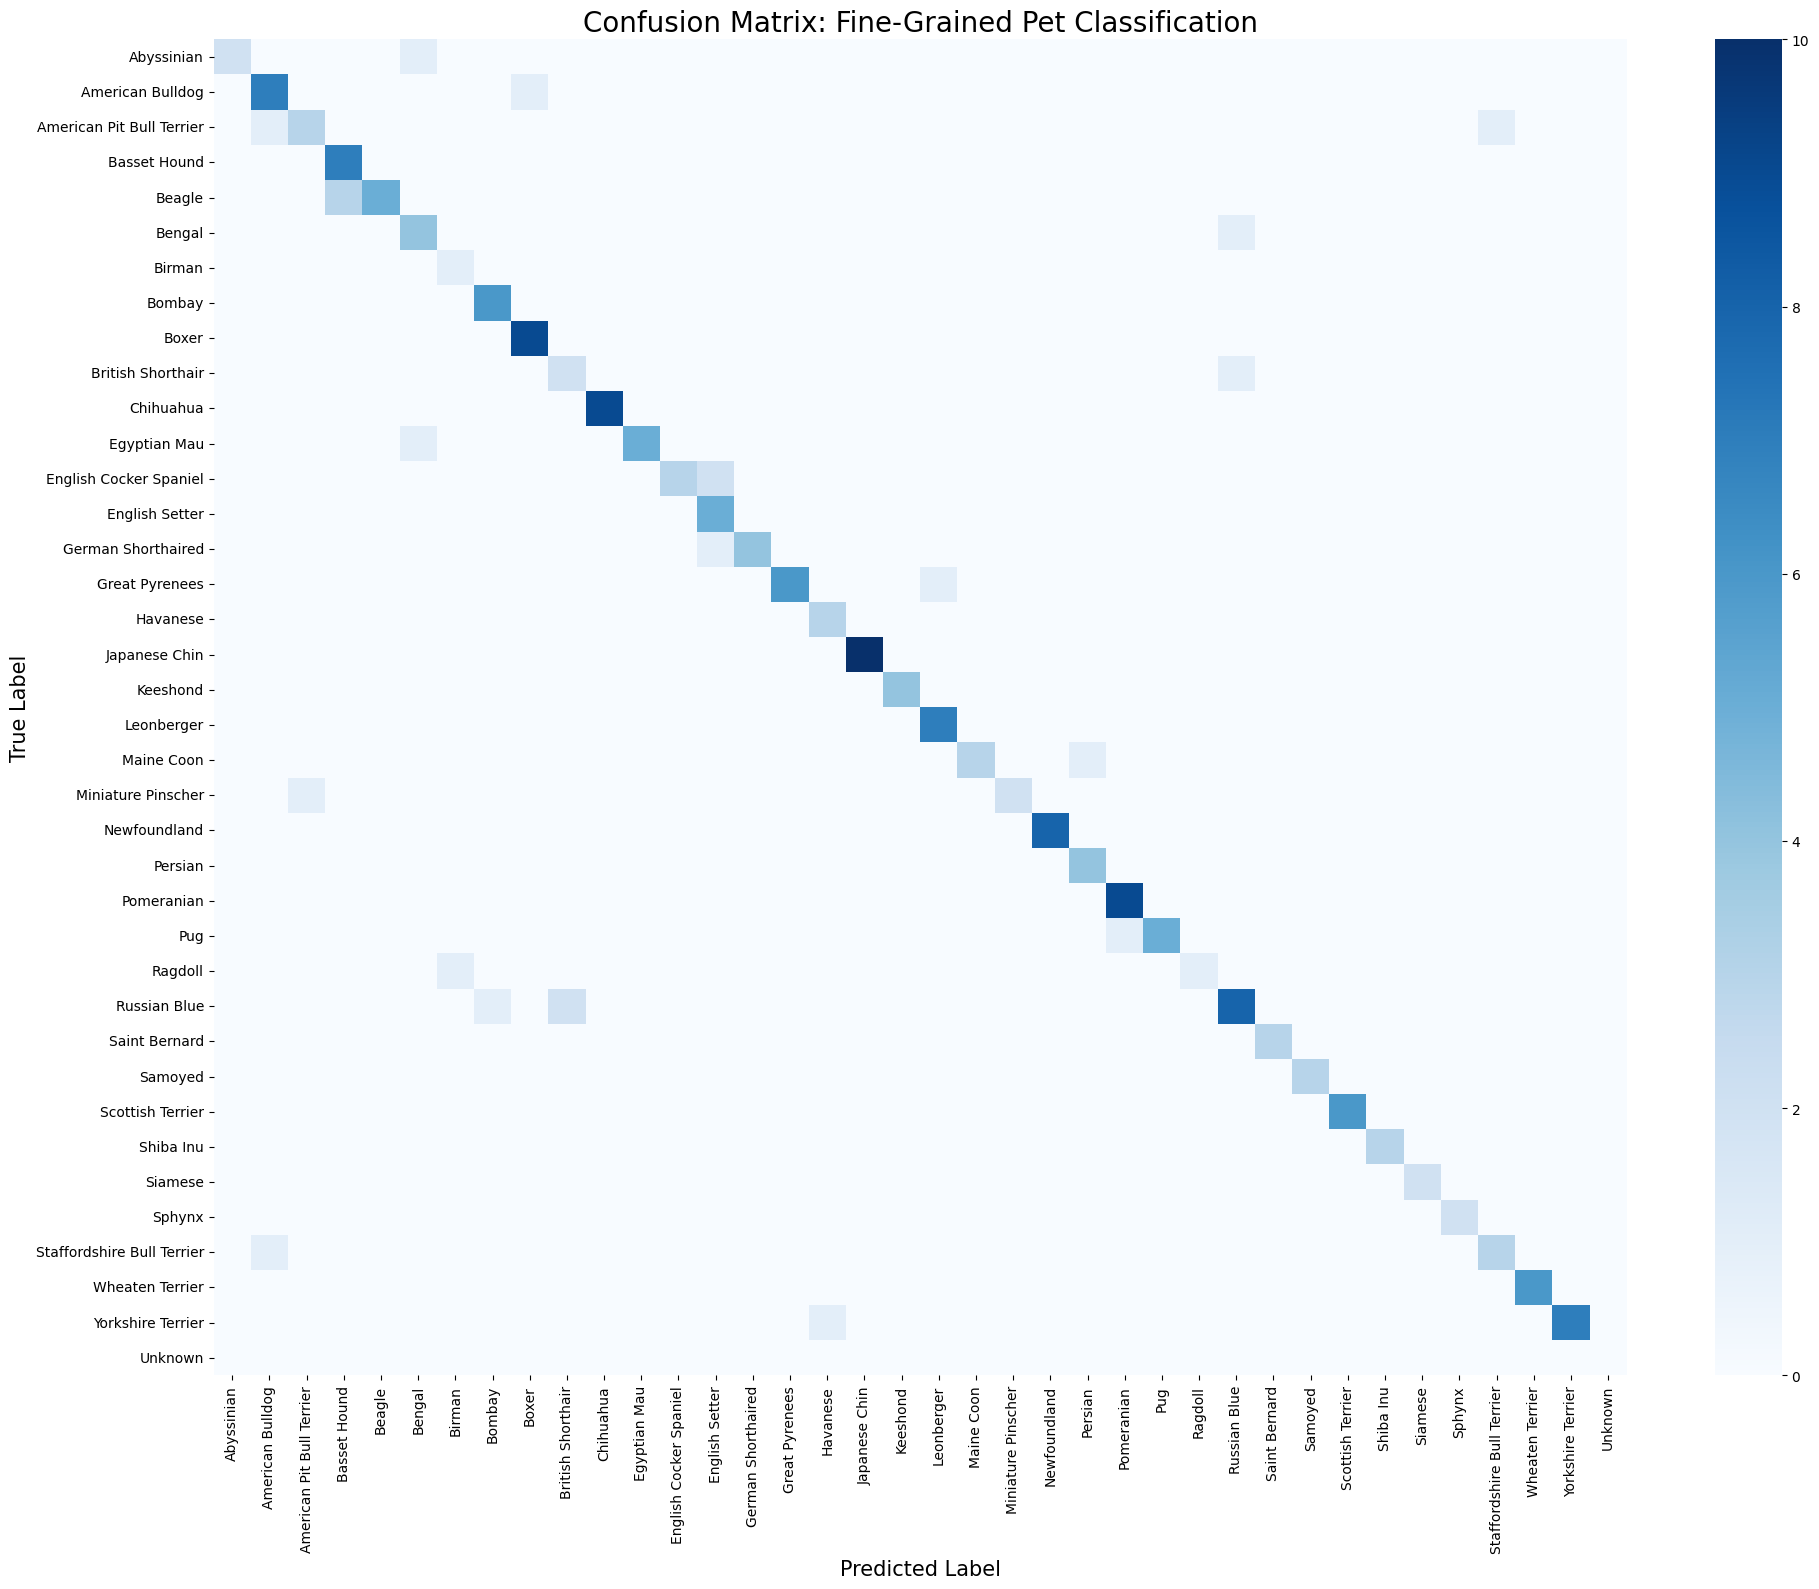


=== Top Confused Pairs (Analysis Insight) ===
Format: True Breed -> Misclassified as -> Count
Beagle -> Basset Hound : 3 times
English Cocker Spaniel -> English Setter : 2 times
Russian Blue -> British Shorthair : 2 times
Abyssinian -> Bengal : 1 times
American Bulldog -> Boxer : 1 times
American Pit Bull Terrier -> American Bulldog : 1 times
American Pit Bull Terrier -> Staffordshire Bull Terrier : 1 times
Bengal -> Russian Blue : 1 times
British Shorthair -> Russian Blue : 1 times
Egyptian Mau -> Bengal : 1 times


In [ ]:
# Confusion Matrix & Error Analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

print("Generating predictions for Confusion Matrix (this takes a moment)...")
eval_range = range(200)

for i in tqdm(eval_range):
    idx = int(len(dataset)*0.9) + i
    item = dataset[idx]
    image = item["image"]
    if image.mode != "RGB": image = image.convert("RGB")

    true_name = id2label[item["label"]]
    y_true.append(true_name)

    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    out = model.generate(**inputs, max_length=50)
    caption = processor.decode(out[0], skip_special_tokens=True)

    found_breed = "Unknown"
    for name in id2label.values():
        if name.lower() in caption.lower():
            found_breed = name
            break # 找到匹配即停止
    y_pred.append(found_breed)

breed_names = list(id2label.values()) + ["Unknown"]
cm = confusion_matrix(y_true, y_pred, labels=breed_names)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, xticklabels=breed_names, yticklabels=breed_names, cmap="Blues", annot=False)
plt.title("Confusion Matrix: Fine-Grained Pet Classification", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

np.fill_diagonal(cm, 0)
pairs = []
for i in range(len(breed_names)):
    for j in range(len(breed_names)):
        if cm[i, j] > 0:
            pairs.append((breed_names[i], breed_names[j], cm[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

print("\n=== Top Confused Pairs (Analysis Insight) ===")
print("Format: True Breed -> Misclassified as -> Count")
for t, p, c in pairs[:10]:
    print(f"{t} -> {p} : {c} times")

Generating Attention Maps for 3 Random Samples...


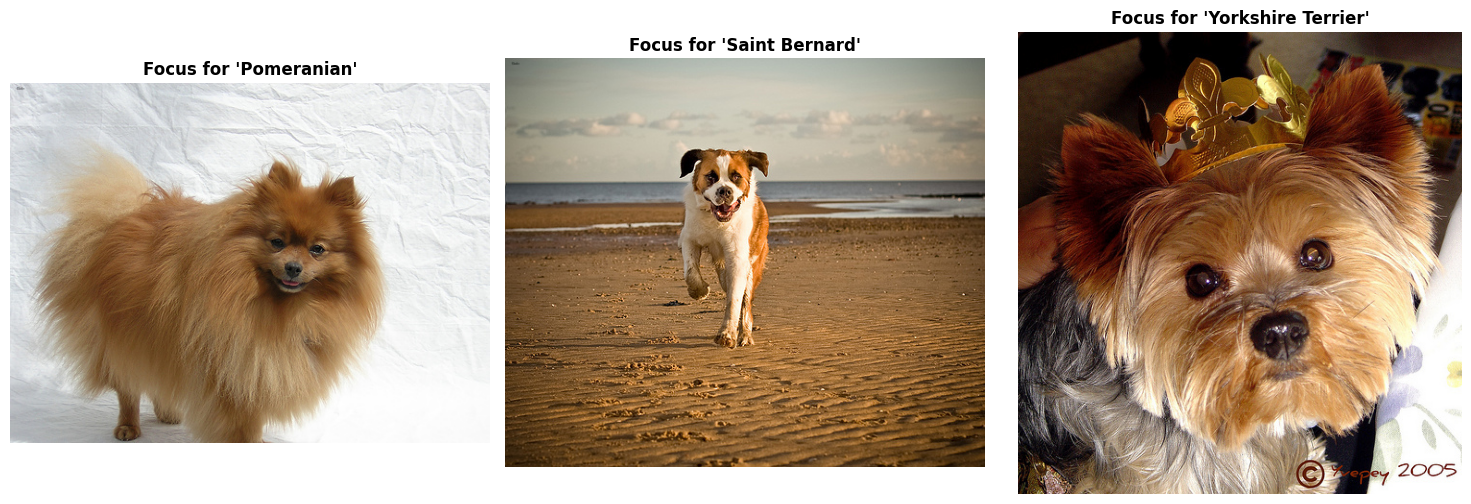

Interpretation: Red/Yellow areas indicate high attention weights.


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()

def visualize_attention(model, processor, image, breed_name):
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    text_prompt = f"A photo of a {breed_name}"
    text_inputs = processor.tokenizer(text_prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(
            pixel_values=inputs.pixel_values,
            input_ids=text_inputs.input_ids,
            output_attentions=True
        )

    if hasattr(outputs, "cross_attentions"):
        last_layer_attn = outputs.cross_attentions[-1]
    else:
        print("Warning: Cross attentions not found in outputs.")
        return np.array(image)

    avg_attn = last_layer_attn.mean(dim=1) # [Batch, Text_Len, Patches]

    breed_attn = avg_attn[0, -2:, :].mean(dim=0) # [Patches]

    num_patches = breed_attn.shape[0]
    grid_size = int(np.sqrt(num_patches))
    attn_map = breed_attn.reshape(grid_size, grid_size).cpu().numpy()

    img_np = np.array(image)
    attn_map = cv2.resize(attn_map, (img_np.shape[1], img_np.shape[0]))

    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    cam = heatmap + np.float32(img_np) / 255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

print("Generating Attention Maps for 3 Random Samples...")

indices = np.random.choice(len(eval_dataset), 3, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    raw_idx = int(int(len(dataset) * 0.9) + int(idx))

    item = dataset[raw_idx]
    image = item["image"]
    if image.mode != "RGB": image = image.convert("RGB")
    breed = id2label[item["label"]]

    try:
        viz_img = visualize_attention(model, processor, image, breed)

        plt.subplot(1, 3, i+1)
        plt.imshow(viz_img)
        plt.title(f"Focus for '{breed}'", fontsize=12, fontweight="bold")
        plt.axis("off")
    except Exception as e:
        print(f"Skipped image due to error: {e}")
        plt.subplot(1, 3, i+1)
        plt.imshow(image)
        plt.title(f"{breed} (Viz Error)", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()
print("Interpretation: Red/Yellow areas indicate high attention weights.")

Plotting Loss Curves...


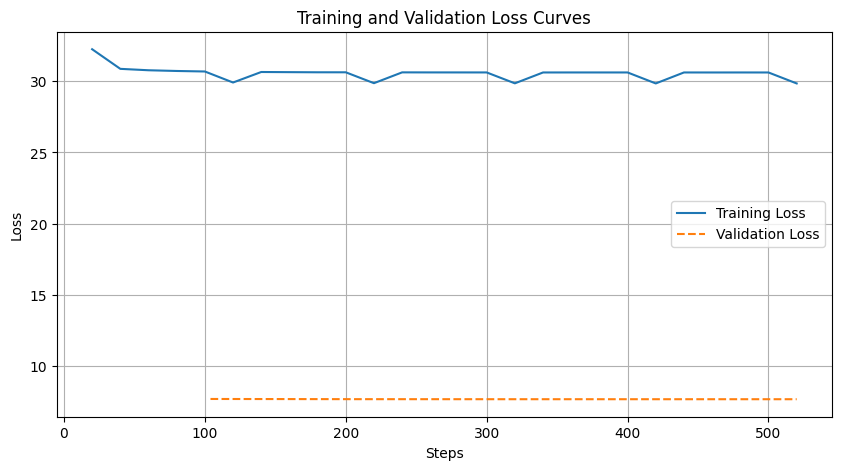

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(trainer):
    log_history = trainer.state.log_history

    train_steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []

    for log in log_history:
        if "loss" in log:
            train_steps.append(log["step"])
            train_loss.append(log["loss"])
        if "eval_loss" in log:
            eval_steps.append(log["step"])
            eval_loss.append(log["eval_loss"])

    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label="Training Loss")
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label="Validation Loss", linestyle="--")

    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

print("Plotting Loss Curves...")
plot_loss_curves(trainer)

In [ ]:
import evaluate
from tqdm import tqdm
import torch

print("Loading metrics...")
try:
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
except Exception as e:
    print(f"Error loading metrics: {e}")
    print("Trying to reinstall rouge_score just in case...")
    !pip install rouge_score
    import evaluate
    rouge = evaluate.load("rouge")

print("Generating captions for full evaluation set (Calculating BLEU/ROUGE)...")

references = []
predictions = []
true_breeds = []

model.eval()

if hasattr(eval_dataset, 'ds'):
    target_data = eval_dataset.ds
else:
    print("Warning: .ds attribute not found, falling back to manual slicing...")
    full_dataset = dataset 
    train_size = int(len(full_dataset) * 0.9)
    target_data = full_dataset.select(range(train_size, len(full_dataset)))

for item in tqdm(target_data):
    image = item["image"]
    label_idx = item["label"]

    if isinstance(label_idx, torch.Tensor):
        label_idx = label_idx.item()

    breed_name = id2label[label_idx]

    ref_text = f"a photo of a {breed_name}, a type of pet."

    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        out = model.generate(**inputs, max_length=50)

    pred_text = processor.decode(out[0], skip_special_tokens=True)

    references.append([ref_text]) 
    predictions.append(pred_text)
    true_breeds.append(breed_name)

print("\nComputing scores...")
bleu_results = bleu.compute(predictions=predictions, references=references)
rouge_results = rouge.compute(predictions=predictions, references=references)

print("\n" + "="*40)
print("RESULTS REPORT (Proposal Requirement)")
print("="*40)
print(f"BLEU Score:    {bleu_results['bleu']:.4f}")
print(f"ROUGE-L Score: {rouge_results['rougeL']:.4f}")
print("="*40)

Loading metrics...
Generating captions for full evaluation set (Calculating BLEU/ROUGE)...


100%|██████████| 368/368 [02:00<00:00,  3.04it/s]



Computing scores...

RESULTS REPORT (Proposal Requirement)
BLEU Score:    0.5569
ROUGE-L Score: 0.9783


In [ ]:
print("\n=== Failure Analysis (Qualitative) ===")
print("Methodology: We classify a prediction as 'Correct' if the ground truth breed name appears in the generated caption string.")

failures = []
for i, (pred, true_breed) in enumerate(zip(predictions, true_breeds)):
    if true_breed.lower() not in pred.lower():
        failures.append((true_breed, pred))

print(f"Total Failures: {len(failures)} out of {len(predictions)}")
print("\nTop 5 Failure Examples (Where the model got it wrong):")
for i, (true, pred) in enumerate(failures[:5]):
    print(f"Example {i+1}:")
    print(f"  - True Breed: [{true}]")
    print(f"  - Generated:  [{pred}]")
    print("-" * 30)


=== Failure Analysis (Qualitative) ===
Methodology: We classify a prediction as 'Correct' if the ground truth breed name appears in the generated caption string.
Total Failures: 50 out of 368

Top 5 Failure Examples (Where the model got it wrong):
Example 1:
  - True Breed: [American Pit Bull Terrier]
  - Generated:  [a photo of a staffordshire bull terrier, a type of pet]
------------------------------
Example 2:
  - True Breed: [Great Pyrenees]
  - Generated:  [a photo of a leonberger, a type of pet]
------------------------------
Example 3:
  - True Breed: [Russian Blue]
  - Generated:  [a photo of a british shorthair, a type of pet]
------------------------------
Example 4:
  - True Breed: [Bengal]
  - Generated:  [a photo of a russian blue, a type of pet]
------------------------------
Example 5:
  - True Breed: [English Cocker Spaniel]
  - Generated:  [a photo of a english setter, a type of pet]
------------------------------


/tmp/ipython-input-1051958446.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=breed_counts.index, y=breed_counts.values, palette="viridis")


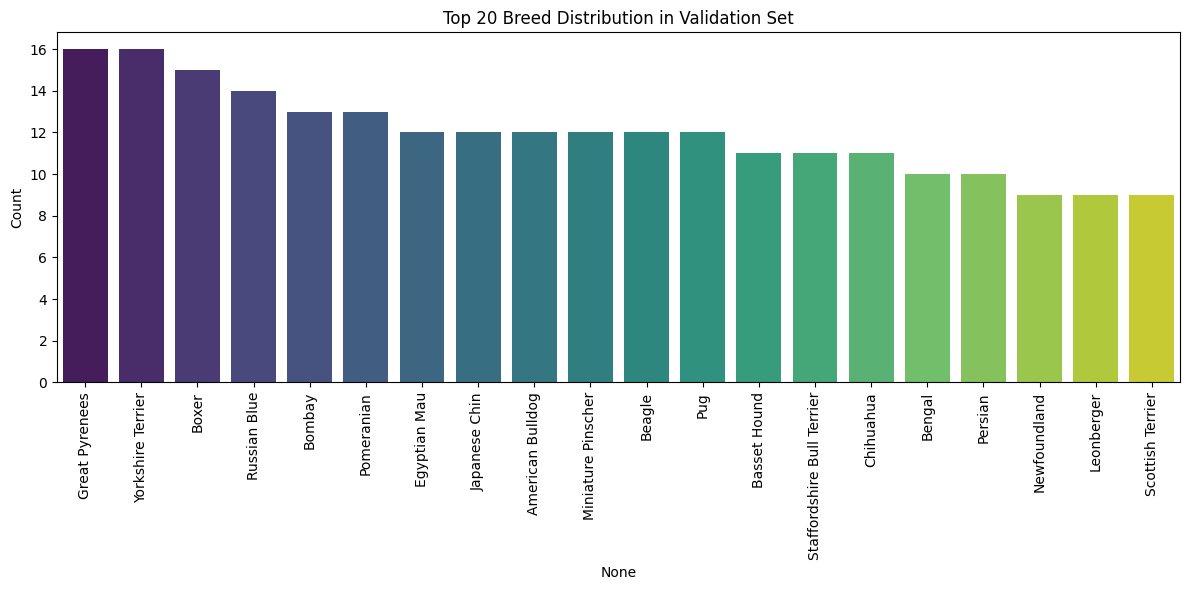

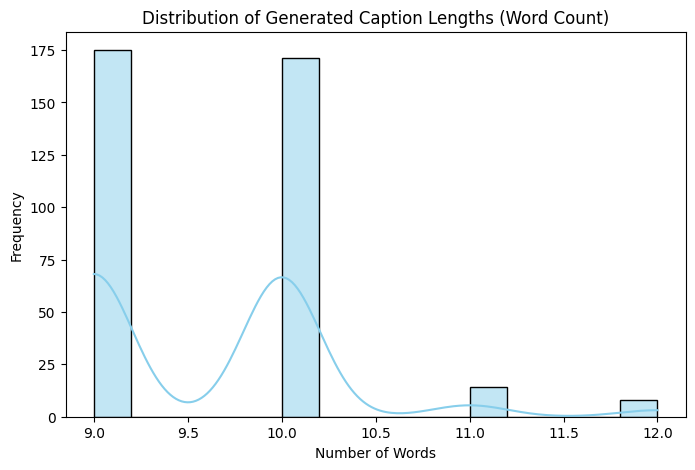

In [ ]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(12, 6))
breed_counts = pd.Series(true_breeds).value_counts().head(20) # 只显示前20个以防太拥挤
sns.barplot(x=breed_counts.index, y=breed_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 20 Breed Distribution in Validation Set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

pred_lengths = [len(p.split()) for p in predictions]
plt.figure(figsize=(8, 5))
sns.histplot(pred_lengths, bins=15, kde=True, color="skyblue")
plt.title("Distribution of Generated Caption Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()